In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Stat"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| code-fold: true
#| output: false
#| code-summary: サブサンプリングなしの Zig-Zag 過程のシミュレーションをする関数 ZZ() を定義
using ZigZagBoomerang
using Distributions
using Random

λ(∇U, x, θ, F::ZigZag1d) = pos(θ*∇U(x)) # rate function on E
λ_bar(τ, a, b) = pos(a + b*τ)  # affine proxy

"""
`x`: current location, `θ`: current velocity, `t`: current time,
"""
function move_forward(τ, t, x, θ, ::ZigZag1d)
    τ + t, x + θ*τ , θ
end

"""
    `∇U`: gradient of the negative log-density
    `(x,θ)`: initial state
    `T`: Time Horizon    
    `a+bt`: computational bound for intensity m(t)

    `num`: ポアソン時刻に到着した回数
    `acc`: 受容回数．`acc/num` は acceptance rate
"""
function ZZ(∇U, x::Float64, θ::Float64, T::Float64, y, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_ZZ)
    t = zero(T)
    Ξ = [(t, x, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(x, θ, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, x, θ = move_forward(τ, t, x, θ, Flow)
        l, lb = λ(∇U, x, θ, Flow), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
            end
            θ = -θ
            push!(Ξ, (t, x, θ))
            push!(epoch_list, num)
        end
        a, b = ab(x, θ, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ

In [3]:
#| output: false
#| code-fold: true
#| code-summary: 今回の設定に応じたレート関数 (a+bt)+ を用意
pos(x) = max(zero(x), x)  # positive part
a(x, θ, ρ, σ, y) = θ * x / ρ^2 + (θ/σ^2) * sum(x .- y)
b(x, θ, ρ, σ, y) = ρ^(-2) + length(y)/σ^2

ρ, σ, x0, θ0 = 1.0, 1.0, 1.0, 1.0
n1, n2 = 100, 10^4
TrueDistribution = Normal(x0, σ)
y1 = rand(TrueDistribution, n1)
y2 = rand(TrueDistribution, n2)

# computational bounds for intensity m(t)
ab_ZZ_n1(x, θ, ::ZigZag1d) = (a(x, θ, ρ, σ, y1), b(x, θ, ρ, σ, y1))
ab_ZZ_n2(x, θ, ::ZigZag1d) = (a(x, θ, ρ, σ, y2), b(x, θ, ρ, σ, y2))

∇U1(x) = x/ρ^2 + (length(y1)/σ^2) * (x - mean(y1)) 
∇U2(x) = x/ρ^2 + (length(y2)/σ^2) * (x - mean(y2)) 

# T = 2500.0
# trace_ZZ1, epochs_ZZ1, acc_ZZ1 = ZZ(∇U1, x0, θ0, T, ZigZag1d(); ab=ab_ZZ_n1)
# trace_ZZ2, num_ZZ2, acc_ZZ2 = ZZ(∇U2, x0, θ0, T, ZigZag1d(); ab=ab_ZZ_n2)
# dt = 0.01
# traj_ZZ1 = discretize(trace_ZZ1, ZigZag1d(), dt)
# traj_ZZ2 = discretize(trace_ZZ2, ZigZag1d(), dt)

∇U2 (generic function with 1 method)

In [4]:
#| output: false
#| code-fold: true
#| code-summary: N 回 ZZ() を実行して，その事後平均の MSE を計算する関数 experiment() を定義
function SquaredError(sample::Vector{Float64}, y)
    True_Posterior_Mean = sum(y) / (length(y) + 1)
    return (mean(sample) - True_Posterior_Mean)^2
end

"""
    epoch_list: 注目するエポック数のリスト
    N: 実験回数
"""
function experiment(epoch_list, T, dt, N, ∇U, x0, θ0, y, Sampler; ab=ab_ZZ_n1)
    SE_sum = zero(epoch_list)
    acc_list = []
    for _ in 1:N
        trace_ZZ1, epochs_ZZ1, acc_ZZ1 = Sampler(∇U, x0, θ0, T, y, ZigZag1d(); ab=ab)
        push!(acc_list, acc_ZZ1)
        traj_ZZ1 = discretize(trace_ZZ1, ZigZag1d(), dt)
        SE_list = []
        for T in epoch_list
            epoch = findfirst(x -> x > T, epochs_ZZ1) - 1
            t = findfirst(x -> x > trace_ZZ1[epoch][1], traj_ZZ1.t) - 1
            SE = SquaredError(traj_ZZ1.x[1:t], y)
            push!(SE_list, SE)
        end
        SE_sum += SE_list
    end
    return SE_sum ./ N, mean(acc_list)
end

experiment

In [5]:
#| code-fold: true
#| code-summary: 実験の実行
using Plots

T = 3000.0
epoch_list = [10.0, 100.0, 1000.0, 10000.0]
dt = 0.01
N = 11

MSE_ZZ1, acc = experiment(epoch_list, T, dt, N, ∇U1, x0, θ0, y1, ZZ; ab=ab_ZZ_n1)
p = plot(#epoch_list, MSE_ZZ1,
    xscale=:log10,
    yscale=:log10,
    xlabel="epochs",
    ylabel="MSE"
    ,background_color = "#F0F1EB"
    )
scatter!(p, epoch_list, MSE_ZZ1,
    marker=:circle,
    markersize=5,
    markeralpha=0.6,
    color="#78C2AD",
    label=nothing
    )

using GLM, DataFrames
df = DataFrame(X = log10.(epoch_list), Y = log10.(MSE_ZZ1))
model = lm(@formula(Y ~ X), df)
X_pred = range(minimum(df.X), maximum(df.X), length=100)
Y_pred = predict(model, DataFrame(X = X_pred))
plot!(p, 10 .^ X_pred, 10 .^ Y_pred,
    line=:solid,
    linewidth=2,
    color="#78C2AD",
    label="ZZ"
    )

# display(p)

println("Average acceptance rate: $acc")

Average acceptance rate: 1.0


In [6]:
#| code-fold: true
#| code-summary: ZZ-SS (ZigZag with Subsampling) の定義
#| output: false

λj(j,x,θ,y) = pos(θ * (x/ρ^2 + length(y)/σ^2 * (x - y[j])))

function ZZ_SS(∇U, x::Float64, θ::Float64, T::Float64, y, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_ZZ)
    t = zero(T)
    Ξ = [(t, x, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(x, θ, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, x, θ = move_forward(τ, t, x, θ, Flow)
        j = rand(1:length(y))
        l, lb = λj(j, x, θ, y), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            if l > lb + 0.01
                # println(l-lb)
                acc += 1  #  overflow を数えるように変更済み！注意！
            end
            θ = -θ
            push!(Ξ, (t, x, θ))
            push!(epoch_list, num)
        end
        a, b = ab(x, θ, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ_SS (generic function with 1 method)

In [7]:
#| code-fold: true
#| code-summary: 実験の実行
using LaTeXStrings

MSE_ZZ_SS, acc = experiment(epoch_list, T, dt, N, ∇U1, x0, θ0, y1, ZZ_SS; ab=ab_ZZ_n1)
println(L"上界 $(a+bt)_+$ を超えてしまう平均的割合: ", "$acc")

上界 $(a+bt)_+$ を超えてしまう平均的割合: 0.4996047268009074


In [8]:
#| code-fold: true
#| code-summary: ZZ-CV (ZigZag with Control Variates) の定義
#| output: false

x_star = mean(y1) / (1 + σ^2/(length(y1) * ρ^2))

C(ρ, σ, y) = ρ^(-2) + length(y)/σ^2
a(x, θ, ρ, σ, y) = pos(θ*∇U1(x_star)) + C(ρ, σ, y) * abs(x - x_star)
b(x, θ, ρ, σ, y) = C(ρ, σ, y)

# New Computational Bounds for ZZ-CV
ab_ZZ_CV(x, θ, ::ZigZag1d) = (a(x, θ, ρ, σ, y1), b(x, θ, ρ, σ, y1))

function ZZ_CV(∇U, x::Float64, θ::Float64, T::Float64, y, Flow::ZigZagBoomerang.ContinuousDynamics; rng=Random.GLOBAL_RNG, ab=ab_ZZ_CV)
    t = zero(T)
    Ξ = [(t, x, θ)]
    num = acc = 0
    epoch_list = [num]
    a, b = ab(x, θ, Flow)
    t′ =  t + poisson_time(a, b, rand())  # イベントは a,b が定める affine proxy に従って生成する

    while t < T
        τ = t′ - t
        t, x, θ = move_forward(τ, t, x, θ, Flow)
        # j = rand(1:length(y))  # 今回はたまたま要らない
        l, lb =λ(∇U, x, θ, Flow), λ_bar(τ, a, b)  # λ が真のレート, λ_bar が affine proxy
        num += 1
        if rand()*lb < l
            acc += 1
            if l > lb + 0.01
                println(l-lb)
            end
            θ = -θ
            push!(Ξ, (t, x, θ))
            push!(epoch_list, num)
        end
        a, b = ab(x, θ, Flow)
        t′ = t + poisson_time(a, b, rand())
    end

    return Ξ, epoch_list, acc/num
end

ZZ_CV (generic function with 1 method)

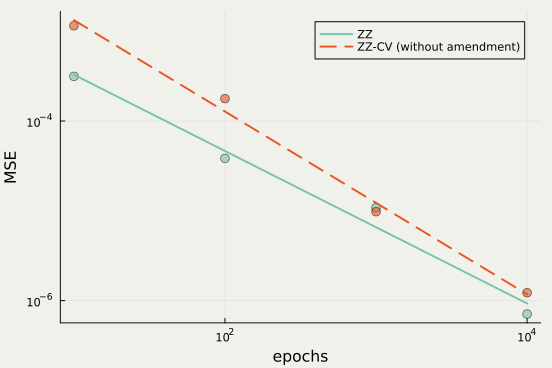

In [9]:
#| code-fold: true
#| code-summary: 実験の実行

MSE_ZZ_CV, acc = experiment(epoch_list, T, dt, N, ∇U1, x0, θ0, y1, ZZ_CV; ab=ab_ZZ_CV)

q = scatter(p, epoch_list, MSE_ZZ_CV,
    marker=:circle,
    markersize=5,
    markeralpha=0.6,
    color="#E95420",
    label=nothing
    )

df = DataFrame(X = log10.(epoch_list), Y = log10.(MSE_ZZ_CV))
model = lm(@formula(Y ~ X), df)
X_pred = range(minimum(df.X), maximum(df.X), length=100)
Y_pred = predict(model, DataFrame(X = X_pred))
plot!(q, 10 .^ X_pred, 10 .^ Y_pred,
    line=:dash,
    linewidth=2,
    color="#E95420",
    label="ZZ-CV (without amendment)"
    )

display(q)

In [10]:
#| output: false
#| echo: false
savefig(q, "MeanOfGaussian_Erronous.svg")

"/Users/hirofumi48/162348.github.io/posts/2024/Stat/MeanOfGaussian_Erronous.svg"

 51.026069 seconds (2.48 G allocations: 46.284 GiB, 6.90% gc time)


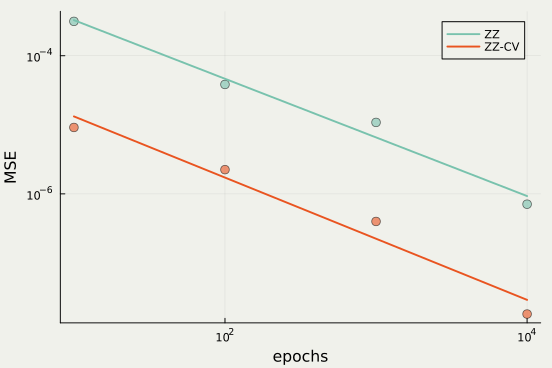

In [11]:
#| code-fold: true
#| code-summary: 実験の実行
T_SuperEfficient = 300000.0
epoch_list_SuperEfficient = [1000.0, 10000.0, 100000.0, 1000000.0]

@time MSE_ZZ_CV, acc = experiment(epoch_list_SuperEfficient, T_SuperEfficient, dt, N, ∇U1, x0, θ0, y1, ZZ_CV; ab=ab_ZZ_CV)

scatter!(p, epoch_list, MSE_ZZ_CV,
    marker=:circle,
    markersize=5,
    markeralpha=0.6,
    color="#E95420",
    label=nothing
    )

df = DataFrame(X = log10.(epoch_list), Y = log10.(MSE_ZZ_CV))
model = lm(@formula(Y ~ X), df)
X_pred = range(minimum(df.X), maximum(df.X), length=100)
Y_pred = predict(model, DataFrame(X = X_pred))
plot!(p, 10 .^ X_pred, 10 .^ Y_pred,
    line=:solid,
    linewidth=2,
    color="#E95420",
    label="ZZ-CV"
    )

display(p)

In [12]:
#| output: false
#| echo: false
savefig(p, "MeanOfGaussian.svg")

"/Users/hirofumi48/162348.github.io/posts/2024/Stat/MeanOfGaussian.svg"

In [13]:
#| code-fold: true
#| code-summary: MALA のセットアップ
#| output: false
using AdvancedHMC, AdvancedMH, ForwardDiff
using LogDensityProblems
using LogDensityProblemsAD
using StructArrays
using LinearAlgebra

struct LogTargetDensity
    y::Vector{Float64}
end

function U(i, x, y)
    x[1] * x[1] / (2 * ρ * ρ) + length(y) * (x[1] - y[i]) * (x[1] - y[i]) / (2 * σ * σ)  # 自動微分のために x は長さ1のベクトルと扱う必要がある
end

function U(x, y)
    vec = [U(i, x, y) for i in 1:length(y)]
    return mean(vec)
end

LogDensityProblems.logdensity(p::LogTargetDensity, x) = U(x, p.y)
LogDensityProblems.dimension(p::LogTargetDensity) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensity}) = LogDensityProblems.LogDensityOrder{0}()

model_with_ad = LogDensityProblemsAD.ADgradient(Val(:ForwardDiff), LogTargetDensity(y1))

# σ² = 0.1 # ほぼ横ばい
σ² = 0.5 # １回小さいエポック10で効率勝った＋全く横ばいになった
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

MALA{RandomWalkProposal{false, var"#21#22"}}(RandomWalkProposal{false, var"#21#22"}(var"#21#22"()))

In [14]:
#| code-fold: true
#| output: false
#| code-summary: 実験の実行
epoch_list = [10.0, 100.0, 1000.0, 10000.0]
N = 10

function experiment_MALA(epoch_list, N, y)
    SE_sum = zero(epoch_list)
    for _ in 1:N
        chain = sample(model_with_ad, spl, Int64(epoch_list[end]); initial_params=[x0], chain_type=StructArray, param_names=["x"], stats=true)
        traj_MALA = Vector{Float64}(chain.x)
        SE_list = []
        for T in epoch_list
            SE = SquaredError(traj_MALA[1:T], y)
            push!(SE_list, SE)
        end
        SE_sum += SE_list
    end
    return SE_sum ./ N
end

MSE_MALA = experiment_MALA(Vector{Int64}(epoch_list), N, y1)

Sampling:  52%|█████████████████████▍                   |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  70%|████████████████████████████▉            |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  74%|██████████████████████████████▍          |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  66%|███████████████████████████▎             |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  70%|████████████████████████████▌            |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  70%|████████████████████████████▌            |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  70%|████████████████████████████▌            |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  70%|████████████████████████████▊            |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  69%|████████████████████████████▎            |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Sampling:  66%|███████████████████████████              |  ETA: 0:00:00

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


4-element Vector{Float64}:
 7.436246438791501e-6
 0.00032082896593448214
 0.00034546449967555866
 0.0009129159308566599

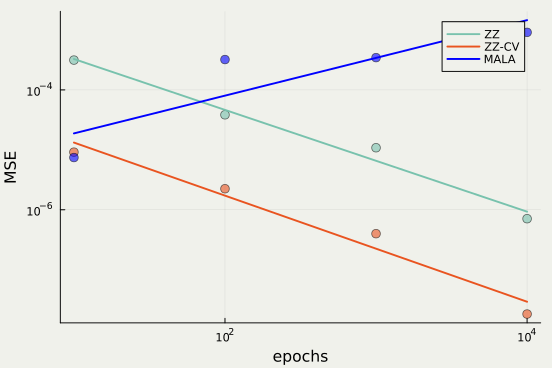

In [15]:
#| code-fold: true
#| code-summary: 結果のプロット
scatter!(p, epoch_list, MSE_MALA,
    marker=:circle,
    markersize=5,
    markeralpha=0.6,
    color="blue",
    label=nothing
    )

df = DataFrame(X = log10.(epoch_list), Y = log10.(MSE_MALA))
model = lm(@formula(Y ~ X), df)
X_pred = range(minimum(df.X), maximum(df.X), length=100)
Y_pred = predict(model, DataFrame(X = X_pred))
plot!(p, 10 .^ X_pred, 10 .^ Y_pred,
    line=:solid,
    linewidth=2,
    color="blue",
    label="MALA"
    )

display(p)

In [16]:
#| output: false
#| echo: false
savefig(p, "MeanOfGaussian_addedMALA.svg")

"/Users/hirofumi48/162348.github.io/posts/2024/Stat/MeanOfGaussian_addedMALA.svg"